<h1 align=center>Anomaly Detection in Time Series with Keras</h1>

<h3> Anomaly Detection</h3>

Anomaly detection (aka outlier analysis) is the process in data mining of identifying unexpected items or events in data sets, which differ from the norm. Anomalous data can indicate critical incidents, such as a technical glitch, or potential opportunities, for instance a change in consumer behavior. Machine learning is progressively being used to automate anomaly detection.

Anomaly detection has two basic assumptions:

1. Anomalies only occur very rarerly in the data
2. Their features differ from the normal instances significantly.

### Project Overview

In this project, we will be detecting anomalies in S&P 500 Time Series data using LSTM Autoencoders using Keras with tensorflow backend.

## Task 1: Import Libraries

In [118]:
import numpy as np
import tensorflow as tf
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

sns.set(style='whitegrid', palette='muted')
rcParams['figure.figsize'] = 16, 6 # set figsize for all images

np.random.seed(1)
tf.random.set_seed(1)

print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.0.0


## Data

The S&P 500, or simply the S&P, is a stock market index that measures the stock performance of 500 large companies listed on stock exchanges in the United States. 

It is one of the most commonly followed equity indices, and many consider it to be one of the best representations of the U.S. stock market.

1. Range: 1986-01-02 --> 2018-06-29
2. Frequency : 'B' --> Business days Mon-Fri

[Data Source](https://www.kaggle.com/pdquant/sp500-daily-19862018) : S&P 500 Daily Prices

## Task 2: Load and Inspect the S&P 500 Index Data

In [122]:
df = pd.read_csv('S&P_500_Index_Data.csv',parse_dates=['date'])
df.head()

,date,close
0,1986-01-02,209.59
1,1986-01-03,210.88
2,1986-01-06,210.65
3,1986-01-07,213.80
4,1986-01-08,207.97


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8192 entries, 0 to 8191
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    8192 non-null   datetime64[ns]
 1   close   8192 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 128.1 KB


In [128]:
# using Plotly for interactive graphs

fig = go.Figure()
fig.add_trace(go.Scatter(x=df['date'],y=df['close'],mode='lines',name='close')) # lines mode for lineplot
fig.update_layout(title='S&P 500',xaxis_title="Time",yaxis_title='INDEXSP',showlegend=True)
fig.show()

## Task 3: Data Preprocessing

In [129]:
train_size = int(len(df) * 0.8) # 80% size for training set
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:]

In [132]:
print(train.shape,test.shape)

(6553, 2) (1639, 2)


Normalizing the data

In [133]:
from sklearn.preprocessing import StandardScaler

scalar = StandardScaler()
scalar = scalar.fit(train[['close']])

train['close'] = scalar.transform(train[['close']])
test['close'] = scalar.transform(test[['close']])

## Task 4: Create Training and Test Splits

The LSTM network takes the input in the form of subsequences of equal intervals of input shape (n_sample,n_timesteps,features). We will use the below custom function to create these sequences

In [144]:
def create_sequences(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [145]:
time_steps = 30

X_train, y_train = create_sequences(train[['close']],train['close'],time_steps)
X_test, y_test = create_sequences(test[['close']],test['close'],time_steps)

In [146]:
print(X_train.shape,y_train.shape)

(6523, 30, 1) (6523,)


## Task 5: Build an LSTM Autoencoder

In [147]:
timesteps = X_train.shape[1]
num_features = X_train.shape[2]

An autoencoder is a neural network model that seeks to learn a compressed representation of an input. They are trained using supervised learning methods, referred to as self-supervised.

In this architecture, an encoder LSTM model reads the input sequence step-by-step. After reading in the entire input sequence, the hidden state or output of this model represents an internal learned representation of the entire input sequence as a fixed-length vector. This vector is then provided as an input to the decoder model that interprets it as each step in the output sequence is generated.

[Autoencoders explained](https://www.youtube.com/watch?v=H1AllrJ-_30)

In [152]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

model = Sequential()
model.add(LSTM(128,input_shape=(timesteps,num_features)))
model.add(Dropout(0.2))
model.add(RepeatVector(timesteps)) # Repeats the input n times.
model.add(LSTM(128,return_sequences=True))
model.add(Dropout(0.2))
model.add(TimeDistributed(Dense(num_features))) # apply a layer to every temporal slice of an input. 

model.compile(loss='mae',optimizer='adam')
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 30, 128)           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 30, 128)           131584    
_________________________________________________________________
dropout_7 (Dropout)          (None, 30, 128)           0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 30, 1)             129       
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
________________________________________________

## Task 6: Train the Autoencoder

In [153]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=3,mode='min') # if the monitored metric does not change wrt to the mode applied for 3 epochs, stop training

In [154]:
history = model.fit(X_train,y_train,epochs=100,batch_size=32,validation_split=0.1,callbacks=[early_stop],shuffle=False)

Train on 5870 samples, validate on 653 samples
Epoch 1/100
5870/5870 [==============================] - 39s 7ms/sample - loss: 0.1509 - val_loss: 0.2013
Epoch 2/100
5870/5870 [==============================] - 31s 5ms/sample - loss: 0.1133 - val_loss: 0.1061
Epoch 3/100
5870/5870 [==============================] - 31s 5ms/sample - loss: 0.0894 - val_loss: 0.0599
Epoch 4/100
5870/5870 [==============================] - 32s 5ms/sample - loss: 0.0795 - val_loss: 0.0398
Epoch 5/100
5870/5870 [==============================] - 32s 5ms/sample - loss: 0.0714 - val_loss: 0.0631
Epoch 6/100
5870/5870 [==============================] - 33s 6ms/sample - loss: 0.0775 - val_loss: 0.0444
Epoch 7/100
5870/5870 [==============================] - 33s 6ms/sample - loss: 0.0717 - val_loss: 0.0330
Epoch 8/100
5870/5870 [==============================] - 32s 6ms/sample - loss: 0.0751 - val_loss: 0.0451
Epoch 9/100
5870/5870 [==============================] - 33s 6ms/sample - loss: 0.0763 - val_loss: 0.0434

## Task 7: Plot Metrics and Evaluate the Model

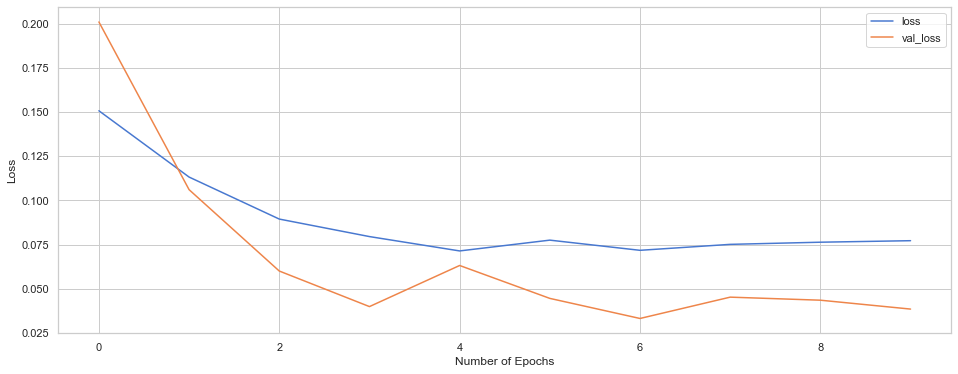

In [156]:
err = pd.DataFrame(history.history)
err.plot()
plt.xlabel('Number of Epochs')
plt.ylabel('Loss');

As our val_loss < loss , we underfit on the training data probably because of the high dropout rate. Feel free to go ahead and change the parameters.

In [157]:
# Calculating the mae for training data
X_train_pred = model.predict(X_train)
train_mae_loss = pd.DataFrame(np.mean(np.abs(X_train_pred - X_train),axis=1),columns=['Error'])

Let's evaluate our model on test data

In [159]:
model.evaluate(X_test,y_test)

1609/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0.293751706463569

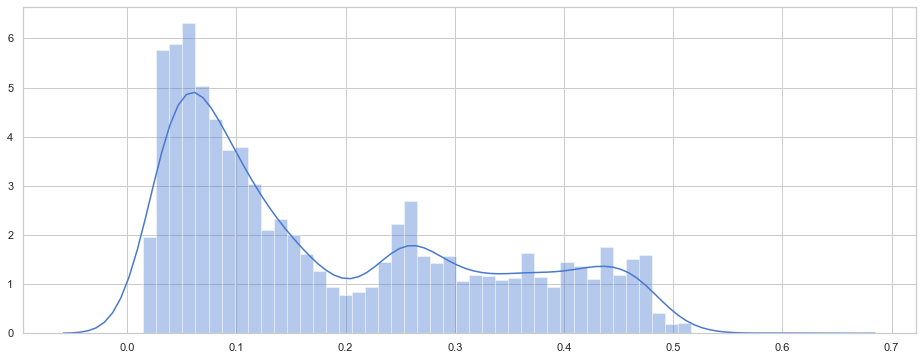

In [161]:
sns.distplot(train_mae_loss,bins=50,kde=True); # Plot histogram of traning losses

As we see there are almost no observations which have training loss more than 0.65

In [162]:
threshold = 0.65

if we notice a error > threshold, we will say that it is an anamoly

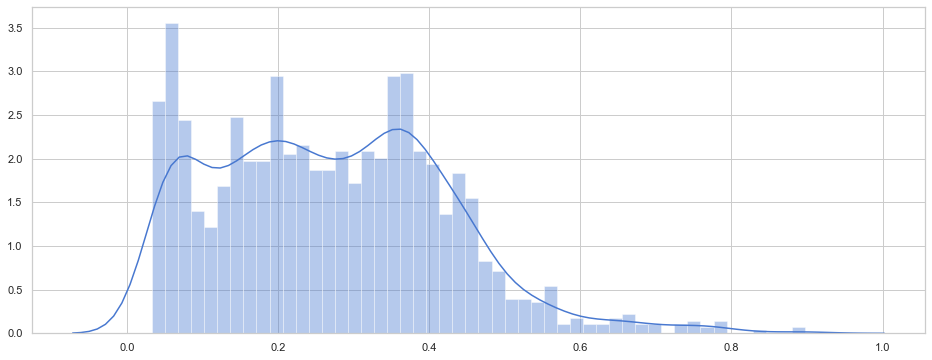

In [175]:
sns.distplot(test_mae_loss, bins=50, kde=True); # Plot histogram of test losses

In [163]:
# Calculate mae for test data
X_test_pred = model.predict(X_test)
test_mae_loss = np.mean(np.abs(X_test_pred - X_test),axis=1)

## Task 8: Detect Anomalies in the S&P 500 Index Data

In [164]:
test_score_df = pd.DataFrame(test[time_steps:])
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = threshold
test_score_df['anomaly'] = test_score_df['loss'] > test_score_df['threshold']
test_score_df['close'] = test[time_steps:]['close']

In [165]:
test_score_df.head()

,date,close,loss,threshold,anomaly
6583,2012-02-08,1.216856,0.064424,0.65,False
6584,2012-02-09,1.221625,0.065769,0.65,False
6585,2012-02-10,1.199313,0.065717,0.65,False
6586,2012-02-13,1.221194,0.056241,0.65,False
6587,2012-02-14,1.218150,0.056590,0.65,False


In [166]:
test_score_df.tail()

,date,close,loss,threshold,anomaly
8187,2018-06-25,4.493228,0.559759,0.65,False
8188,2018-06-26,4.507583,0.609750,0.65,False
8189,2018-06-27,4.451431,0.622985,0.65,False
8190,2018-06-28,4.491406,0.656072,0.65,True
8191,2018-06-29,4.496343,0.645957,0.65,False


In [168]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test[time_steps:]['date'],y=test_score_df['loss'],mode='lines',name='Test Loss'))
fig.add_trace(go.Scatter(x=test[time_steps:]['date'],y=test_score_df['threshold'],mode='lines',name='Threshold'))
fig.update_layout(xaxis_title='Time',yaxis_title='Loss',showlegend=True)
fig.show()

In [169]:
anomalies = test_score_df[test_score_df['anomaly']==True]
anomalies.head()

,date,close,loss,threshold,anomaly
7474,2015-08-25,2.457439,0.667675,0.65,True
7475,2015-08-26,2.632149,0.743101,0.65,True
7476,2015-08-27,2.745147,0.658718,0.65,True
8091,2018-02-06,4.440671,0.742309,0.65,True
8092,2018-02-07,4.408365,0.758599,0.65,True


In [171]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test[time_steps:]['date'],y=scalar.inverse_transform(test[time_steps:]['close']),mode='lines',name='Close Price'))
fig.add_trace(go.Scatter(x=anomalies['date'],y=scalar.inverse_transform(anomalies['close']),mode='markers',name='Anomaly'))
fig.update_layout(xaxis_title='Time',yaxis_title='INDEXSP',showlegend=True)
fig.show()